# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

%config InlineBackend.figure_format='retina'

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
#df_offers = pd.read_excel("./WineKMC.xlsx")
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
# Not sure why the n column is there. I will drop it.
df_table = pd.pivot_table(df_transactions.drop(['n'],axis=1), values=['offer_id'], index=['offer_id'],
                          columns=['customer_name'], aggfunc=len, fill_value=0)

# Transpose
df_table = df_table.transpose()

df_table

offer_id       1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  \
customer_name                                          ...                   
Adams           0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Allen           0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   
Anderson        0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   
Bailey          0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   
...            ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
Williams        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Wilson          0   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   
Wood            1   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   
Wright          0   0   0   1   0   1   0   0   0   0  ...   0   0   0   0   
Young           0   0   0   0   0   1   0   0   1   0  ...   0   0   0   0   

offer_id       27  28  29  30  31  32  
customer_name                          
Adams           0   0   1   1   0   0  
Allen           1   0   0   0   0   0  
Anderson        0   0   0   0   0   0  
Bailey          0   0   0   1   0   0  
Baker           0   0   0   0   1   0  
...            ..  ..  ..  ..  ..  ..  
Williams        0   0   0   0   1   0  
Wilson          0   0   0   1   0   0  
Wood            0   0   0   0   1   0  
Wright          1   0   0   0   0   0  
Young           0   0   0   0   1   1  

[100 rows x 32 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [5]:
# Import libraries
from sklearn.cluster import KMeans

# There is no need to remove the index of the dataframe to contain only the zeros and ones
x_cols = df_table

In [6]:

inertia = []

k_start = 2
k_end = 10

for k in range(k_start,k_end+1):
    
    # Initialize KMeans object with randomized state
    km = KMeans(n_clusters=k,random_state=10)
    
    km.fit(x_cols)
    
    inertia.append(km.inertia_)
    

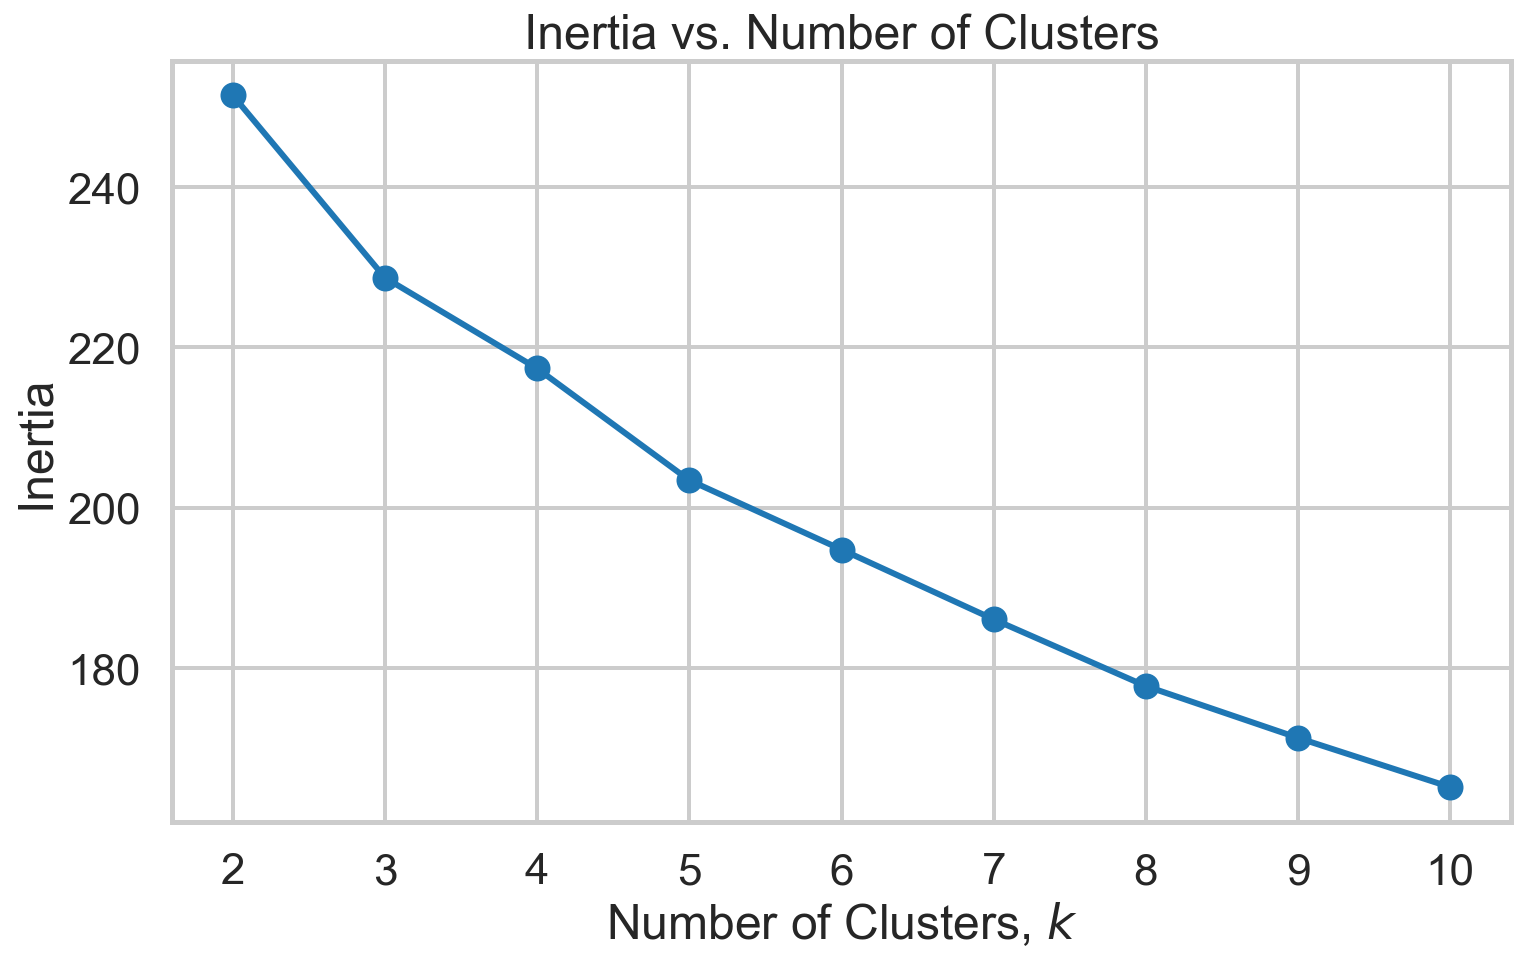

In [7]:
# Plot data
k_values = list(range(k_start,k_end+1))

plt.figure(figsize=(12,7))
plt.plot(k_values,inertia,marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters, $k$')
plt.ylabel('Inertia')
plt.grid;

From the above, it is difficult to properly get the best number of centroids clearly. However, let us assume two potential K values, i.e. 3 and 8. 

In [8]:
km3 = KMeans(n_clusters=3,random_state=0)
km3.fit(x_cols);

km8 = KMeans(n_clusters=8,random_state=0)
km8.fit(x_cols);

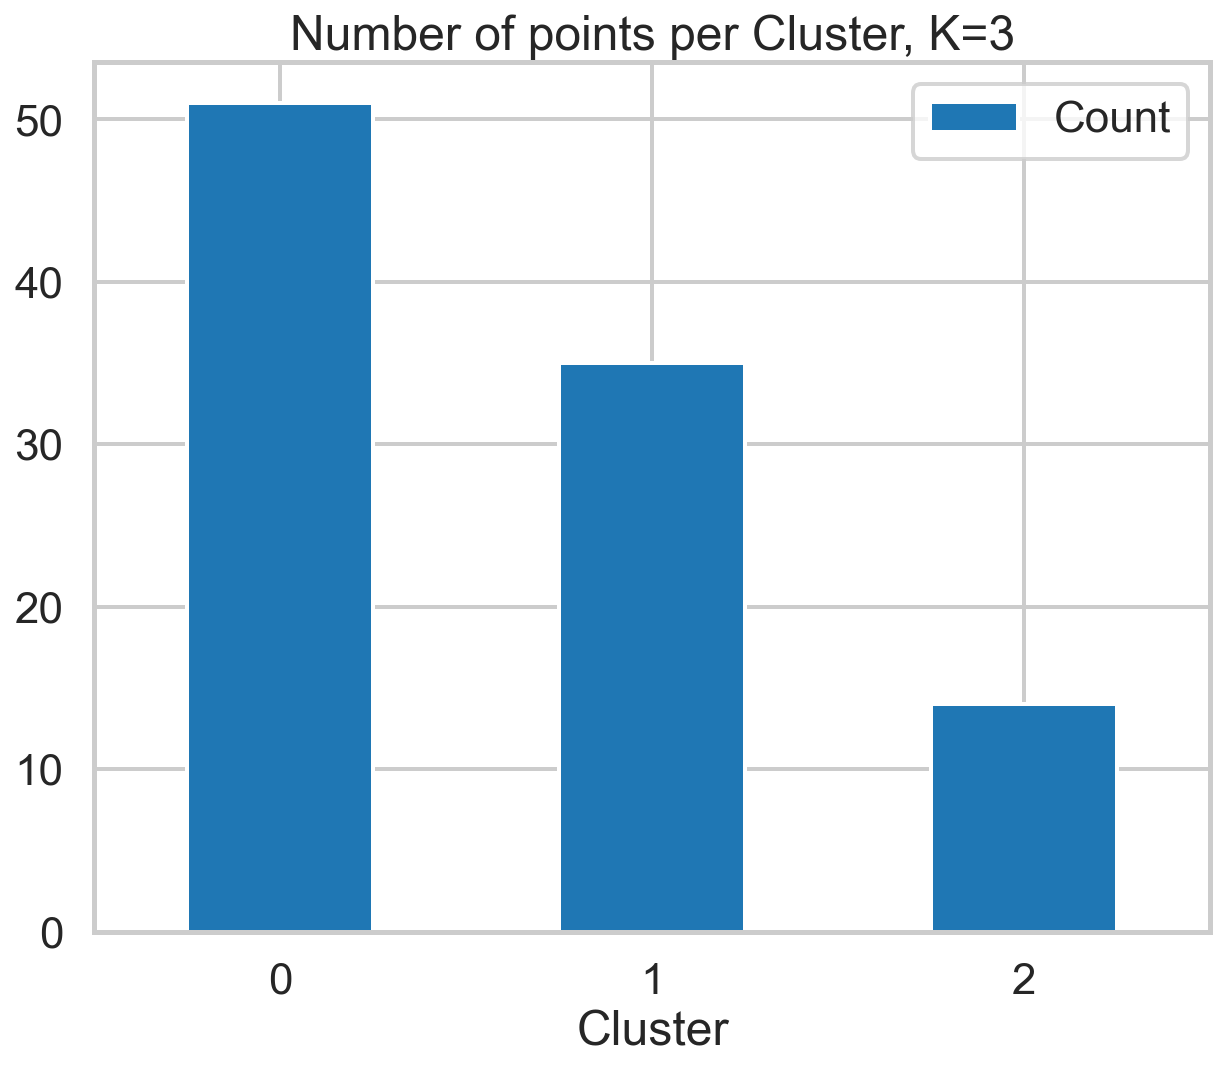

In [9]:
from collections import Counter

# Create dataframe
C3 = Counter(list(km3.labels_))
df3 = pd.DataFrame.from_dict(C3, orient='index').reset_index().sort_values(by='index')
df3 = df3.reset_index(drop=True)

# Rename columns
df3 = df3.rename(columns={'index':'Cluster', 0:'Count'})

ax = df3.plot(x='Cluster', y='Count', rot=0, kind='bar',
              title = 'Number of points per Cluster, K=3', figsize=(10,8))

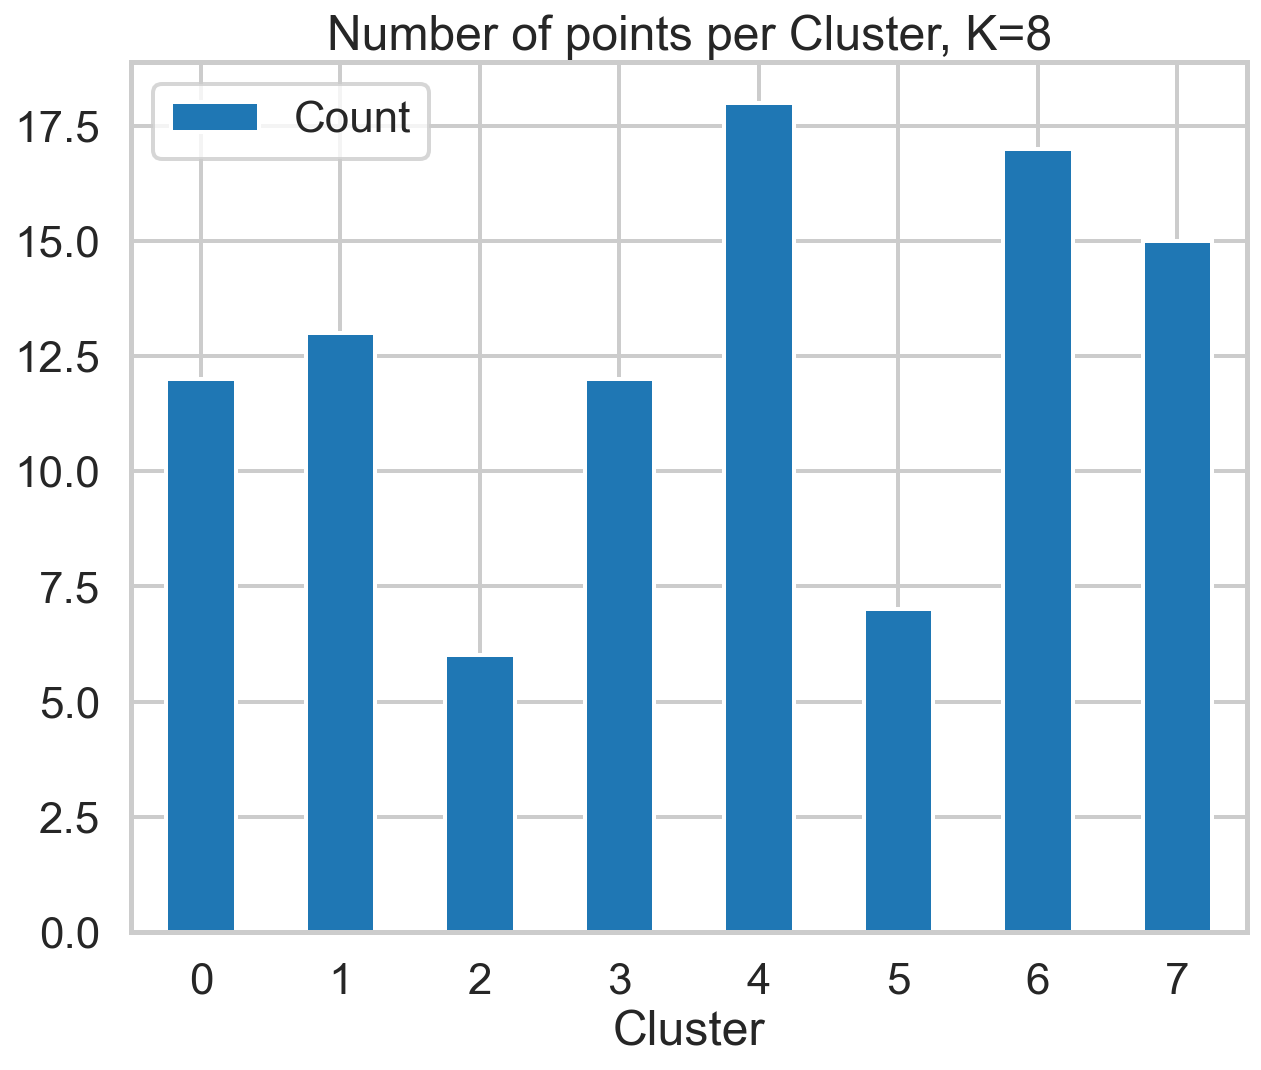

In [10]:
# Create dataframe
C8 = Counter(list(km8.labels_))
df8 = pd.DataFrame.from_dict(C8, orient='index').reset_index().sort_values(by='index')
df8 = df8.reset_index(drop=True)

# Rename columns
df8 = df8.rename(columns={'index':'Cluster', 0:'Count'})

ax = df8.plot(x='Cluster', y='Count', rot=0, kind='bar',
              title = 'Number of points per Cluster, K=8', figsize=(10,8))

Again, the elbow method for determining the optimal is not as clear here. For K=3, the number of points within a cluster decreases but for K=8, it varies. Perhaps using the Silhoutte method could work.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.08911656187360473
For n_clusters = 3 The average silhouette_score is : 0.11015391298263667
For n_clusters = 4 The average silhouette_score is : 0.12941883590155936
For n_clusters = 5 The average silhouette_score is : 0.13911006290392372
For n_clusters = 6 The average silhouette_score is : 0.10979895247757922
For n_clusters = 7 The average silhouette_score is : 0.11326943929616652
For n_clusters = 8 The average silhouette_score is : 0.13198496281110994
For n_clusters = 9 The average silhouette_score is : 0.1291115731137975
For n_clusters = 10 The average silhouette_score is : 0.1216086963107709


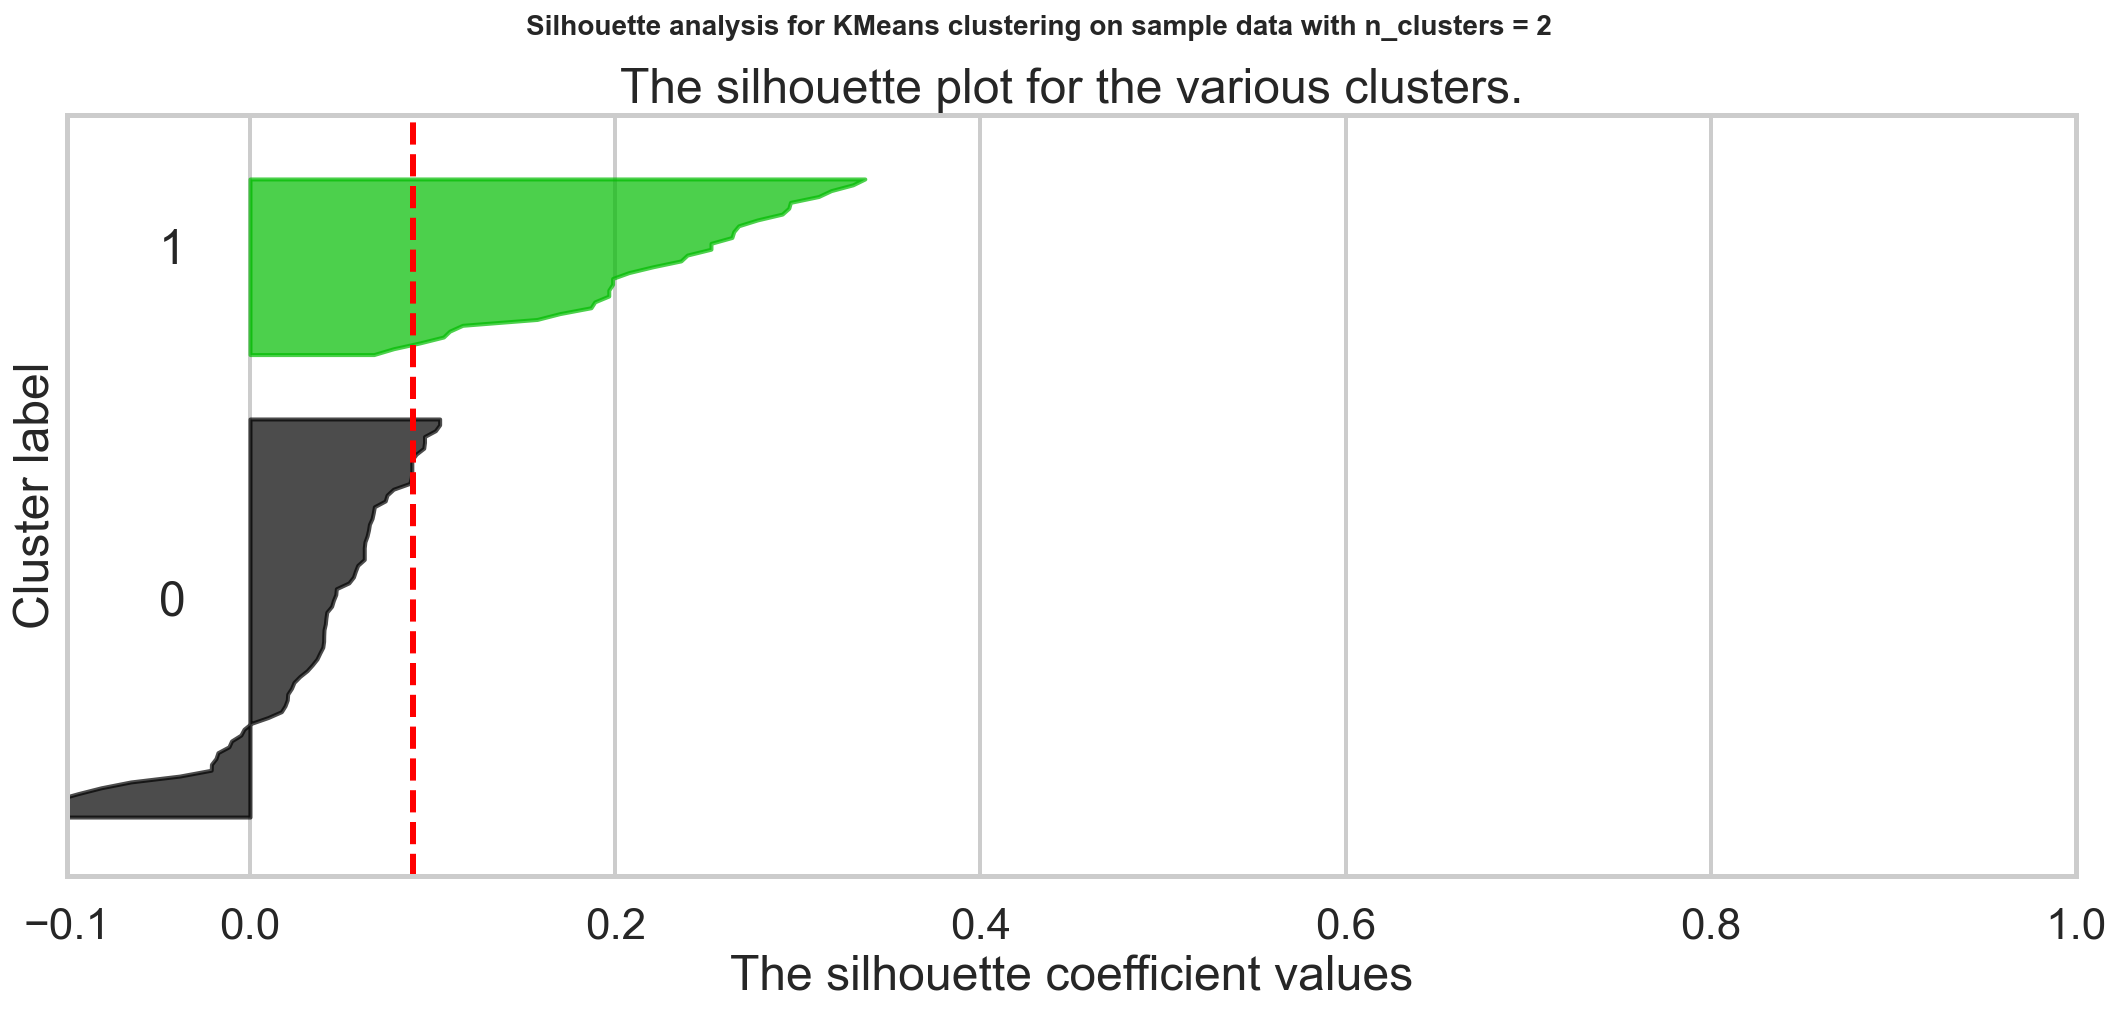

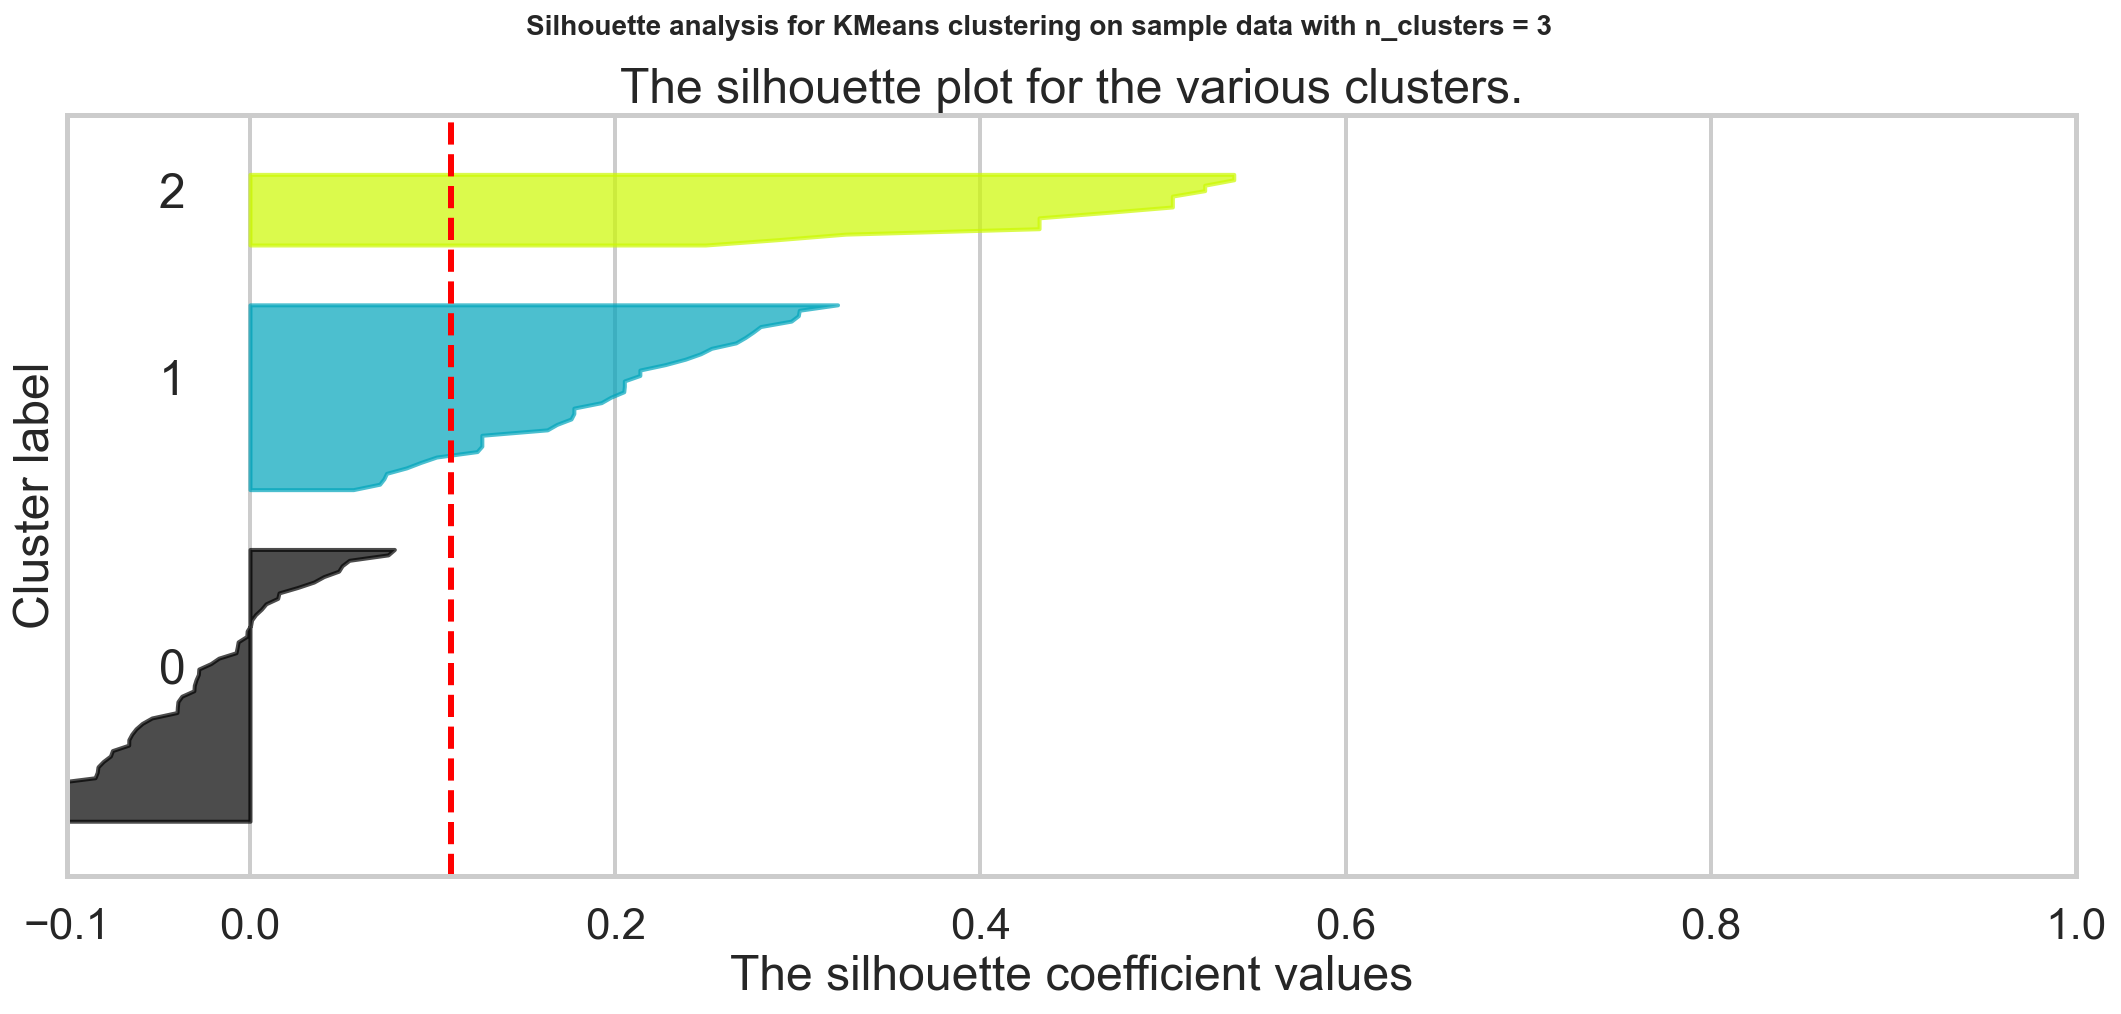

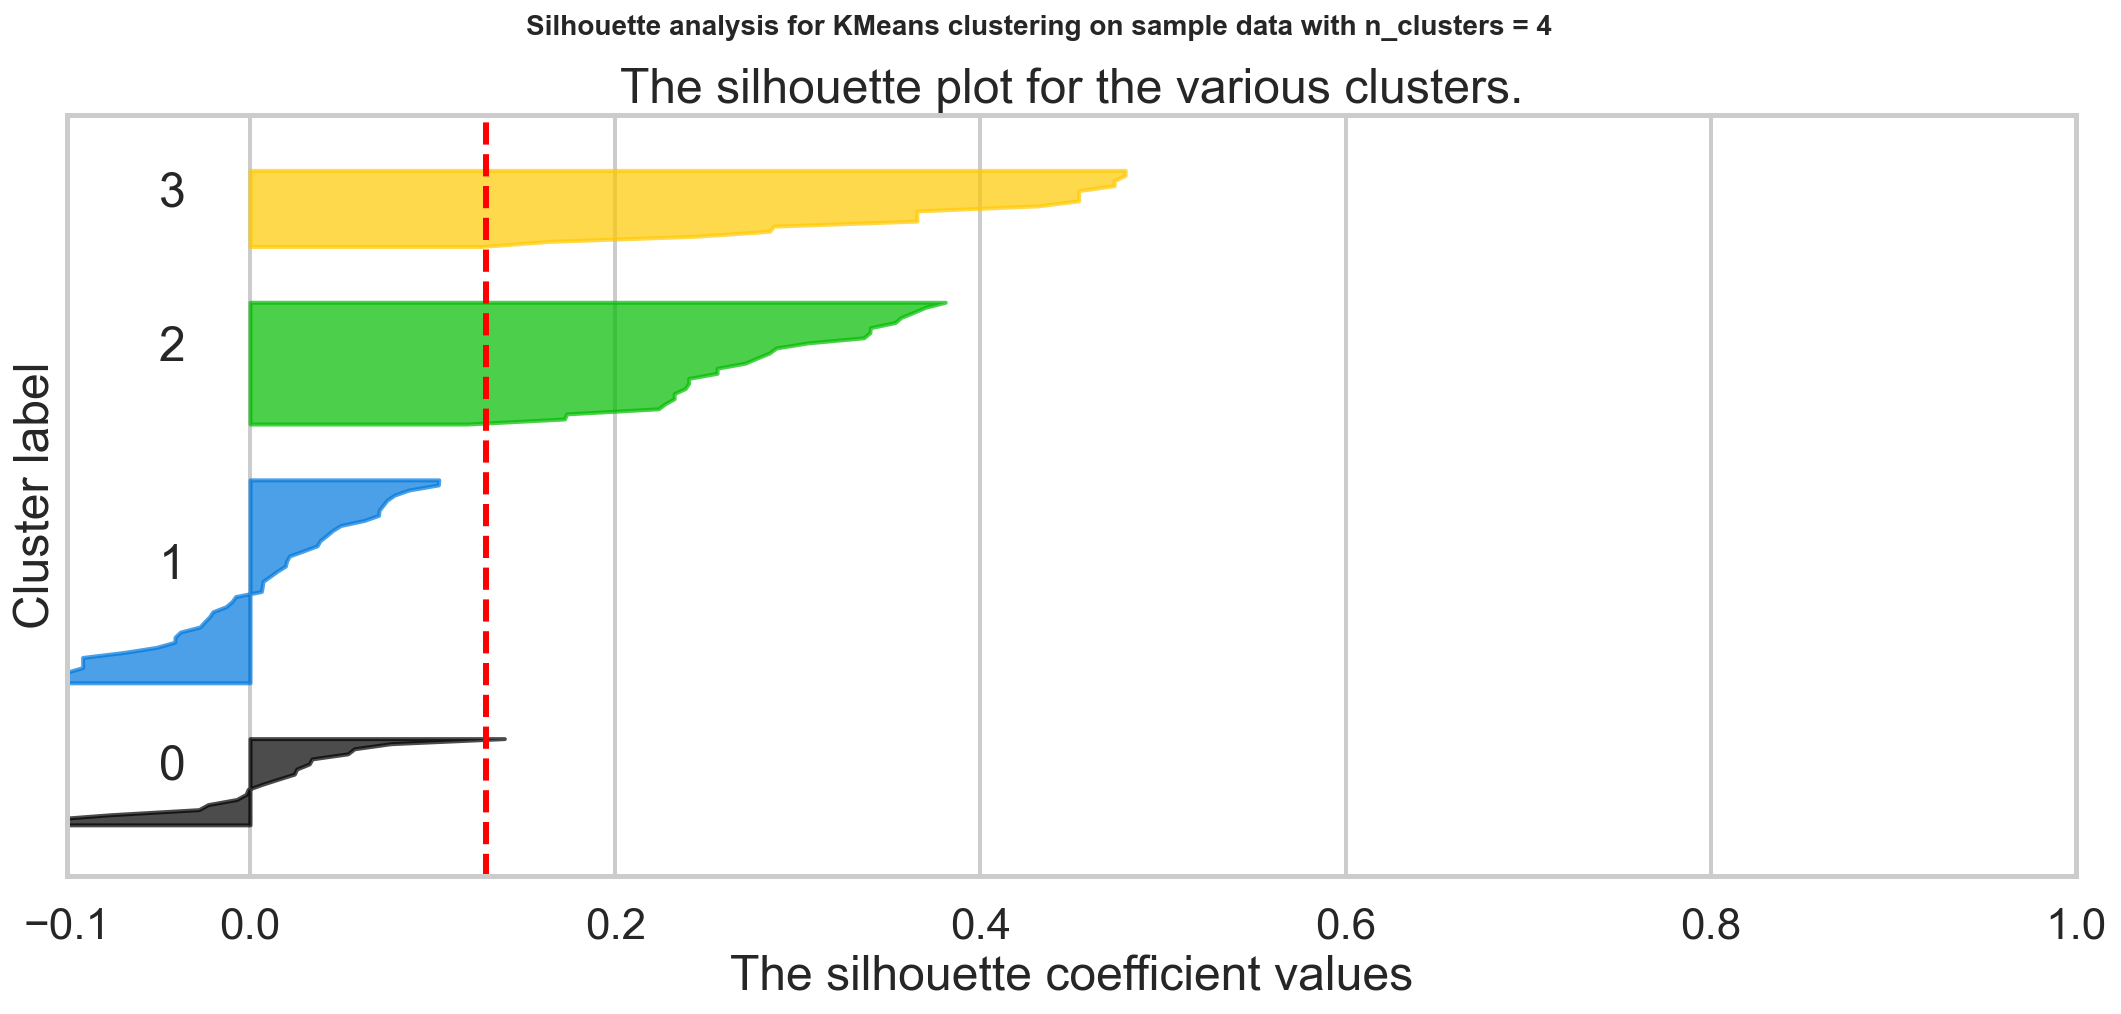

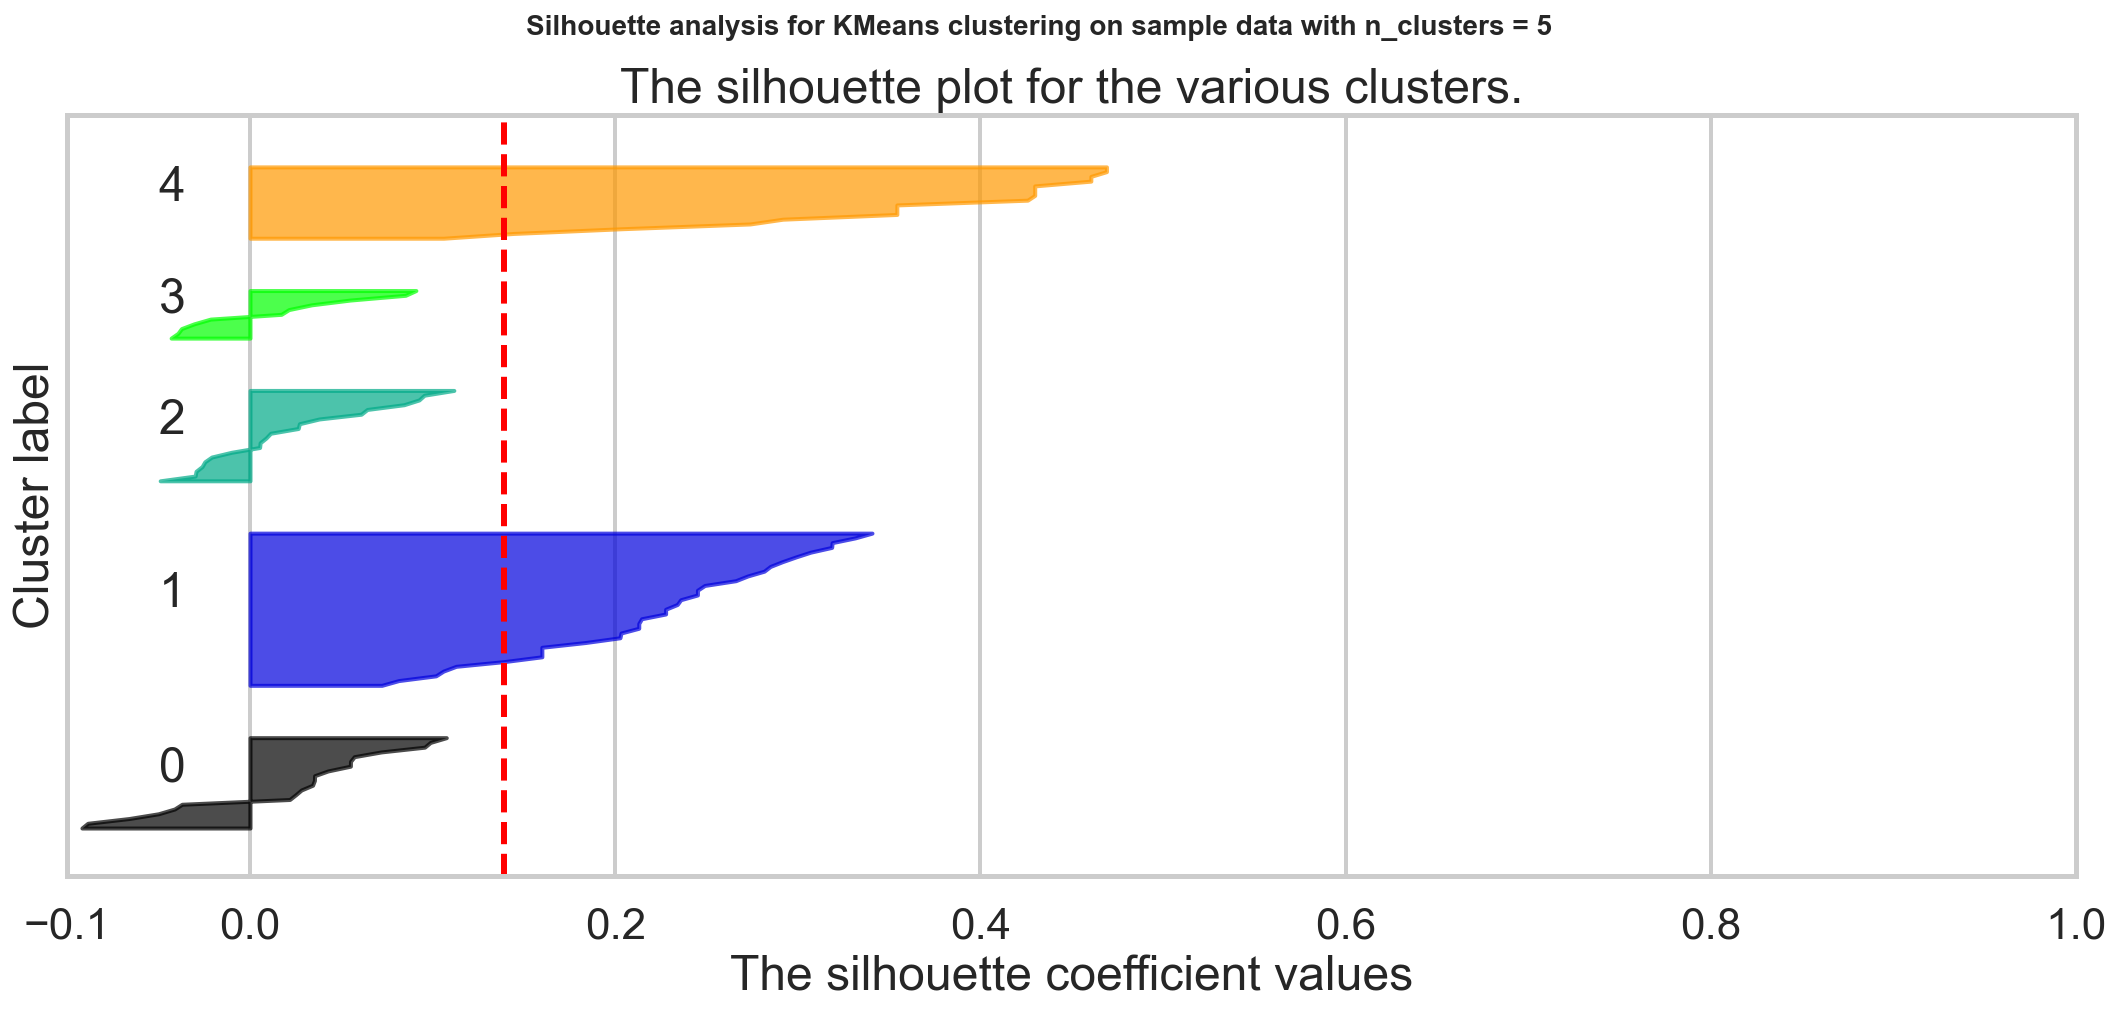

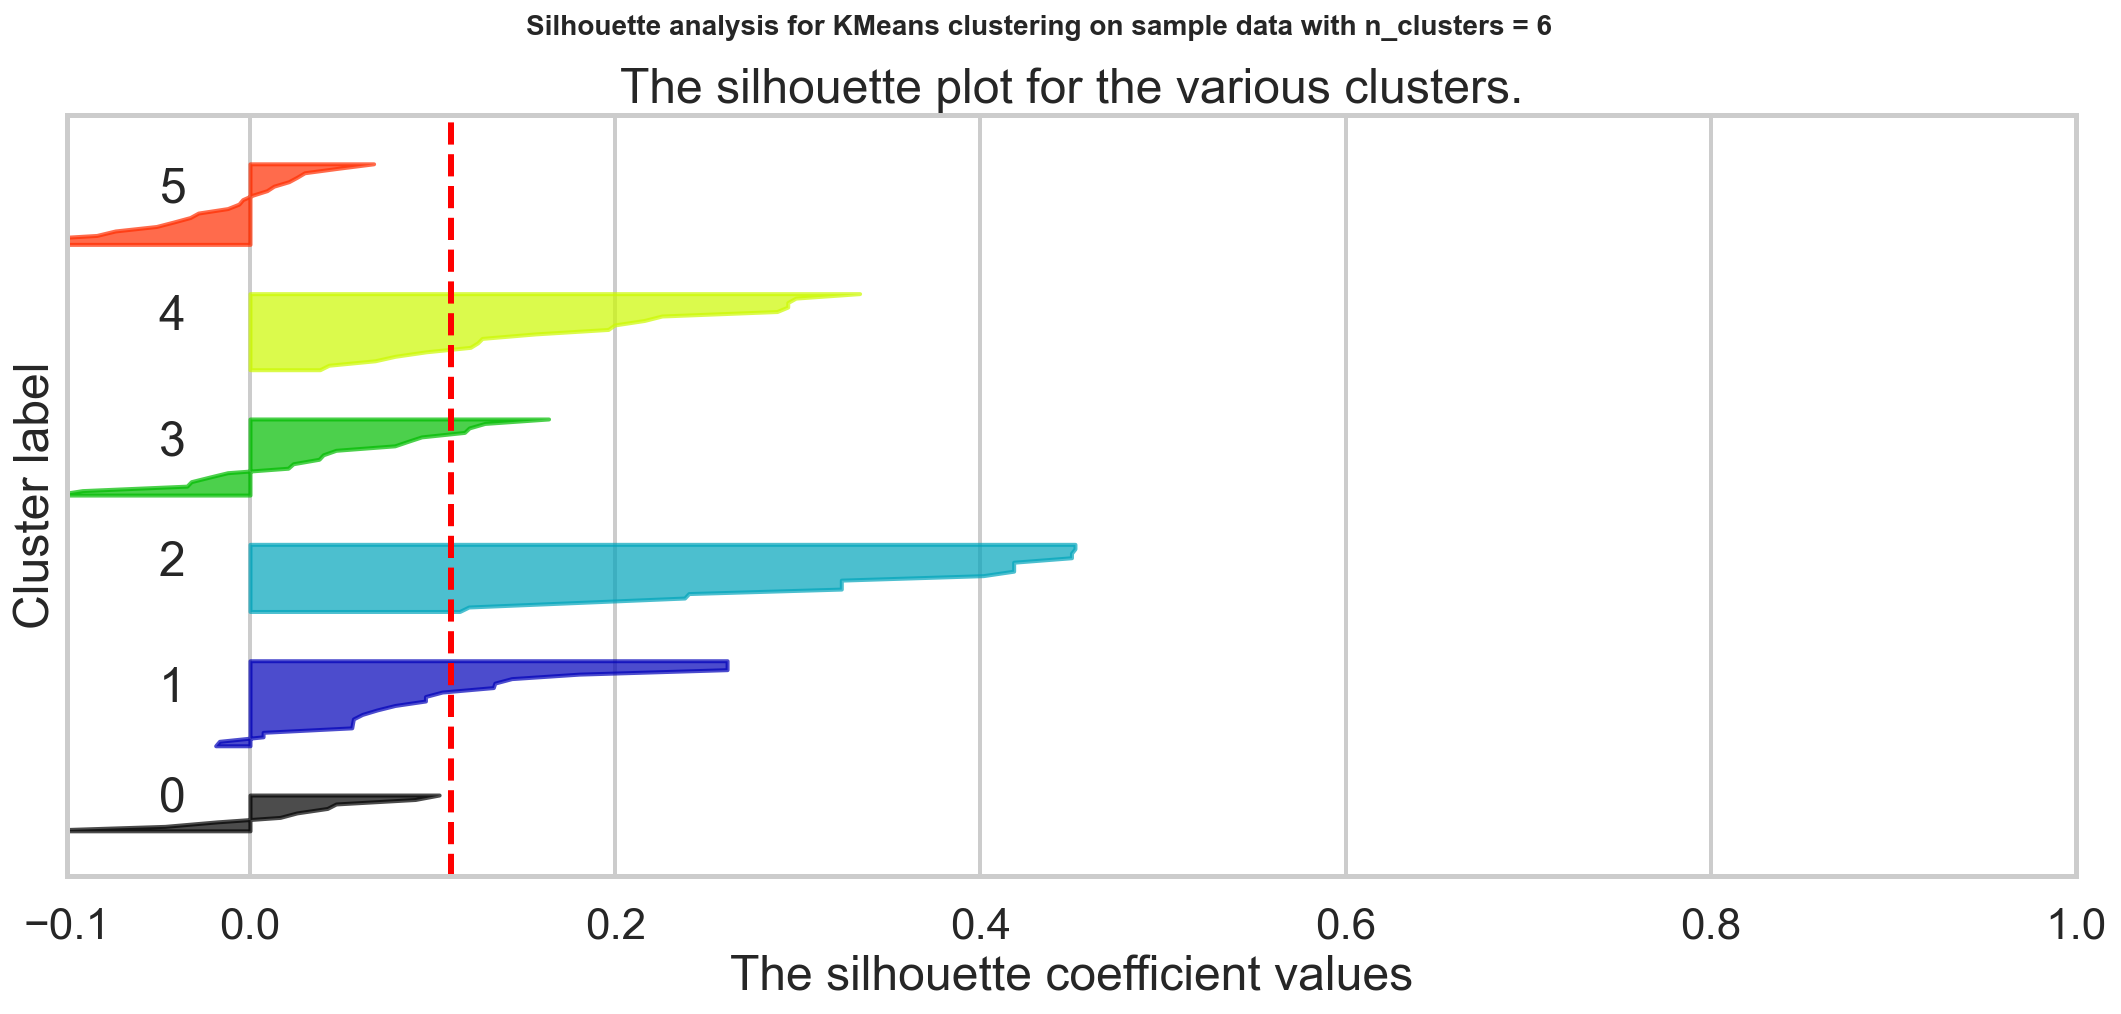

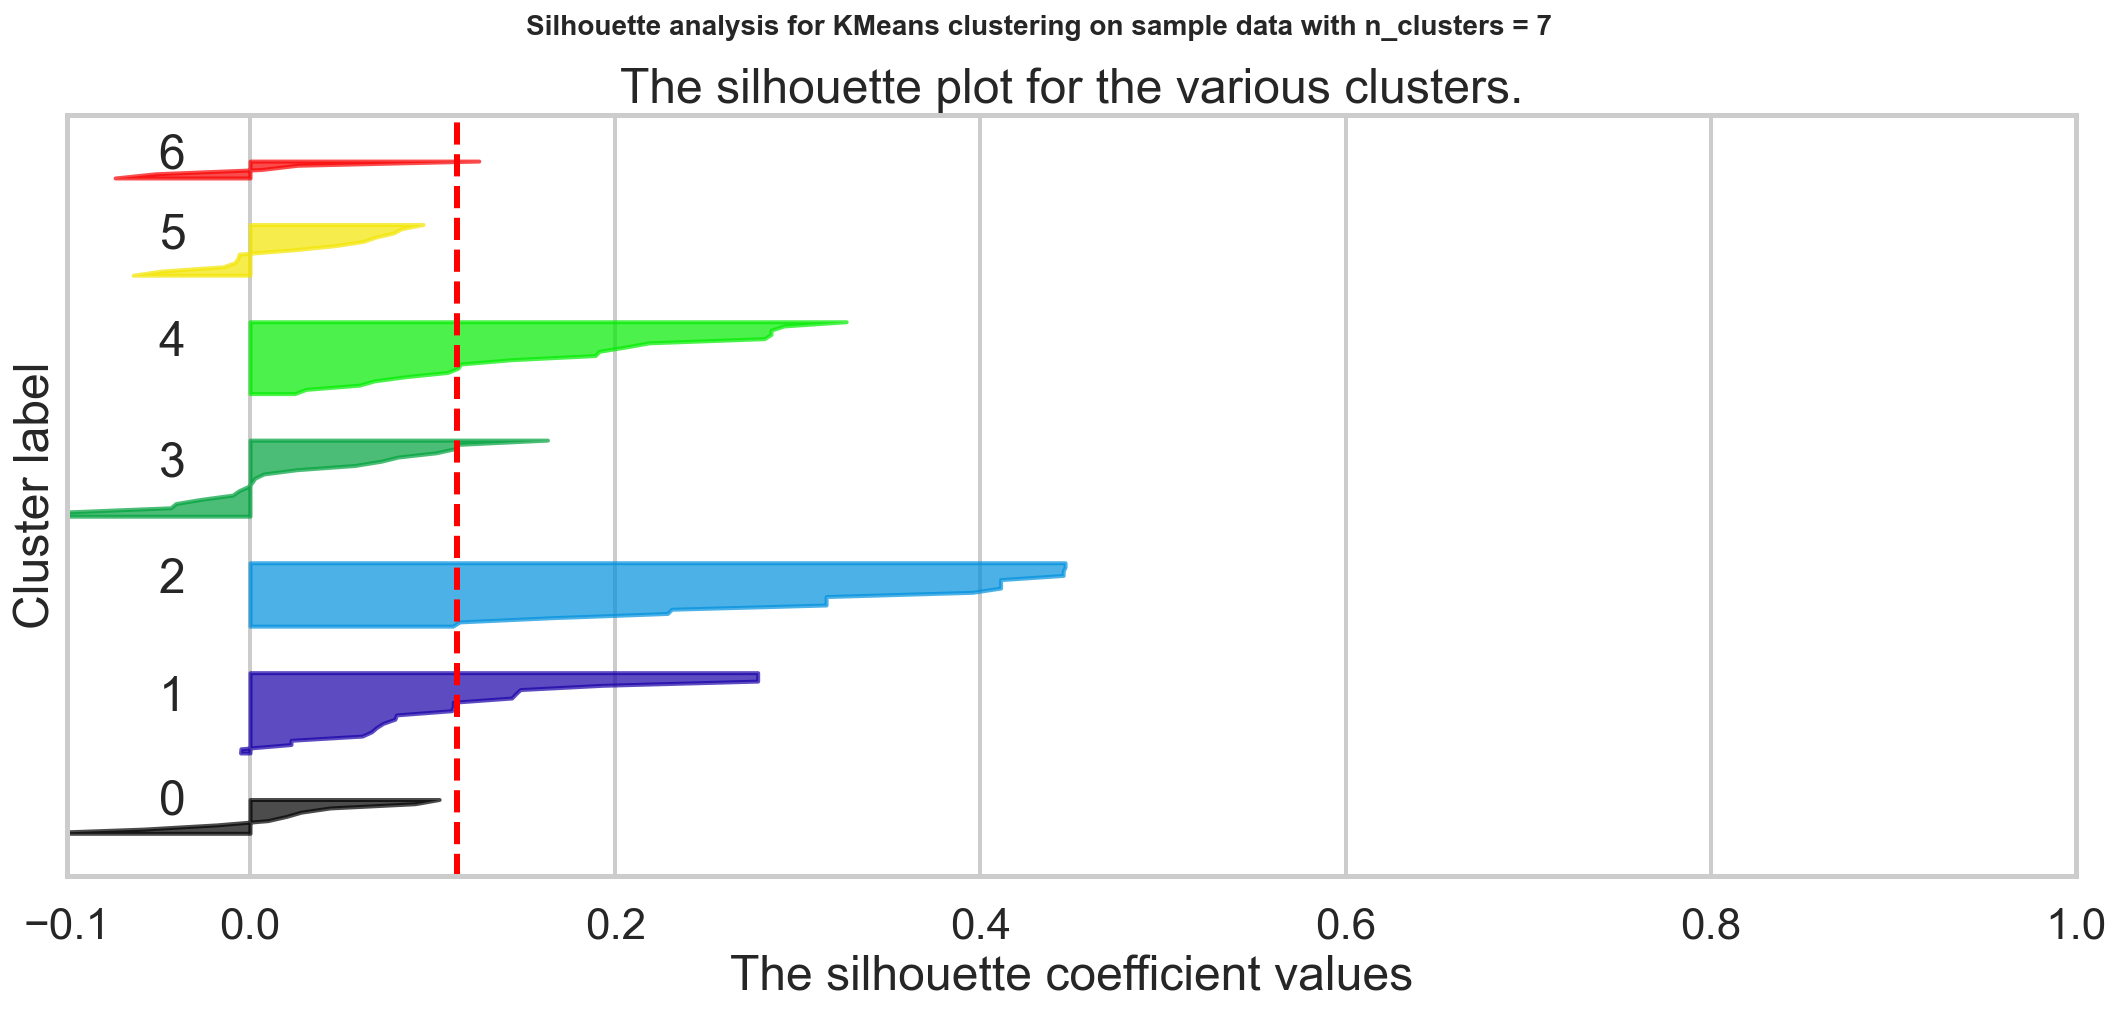

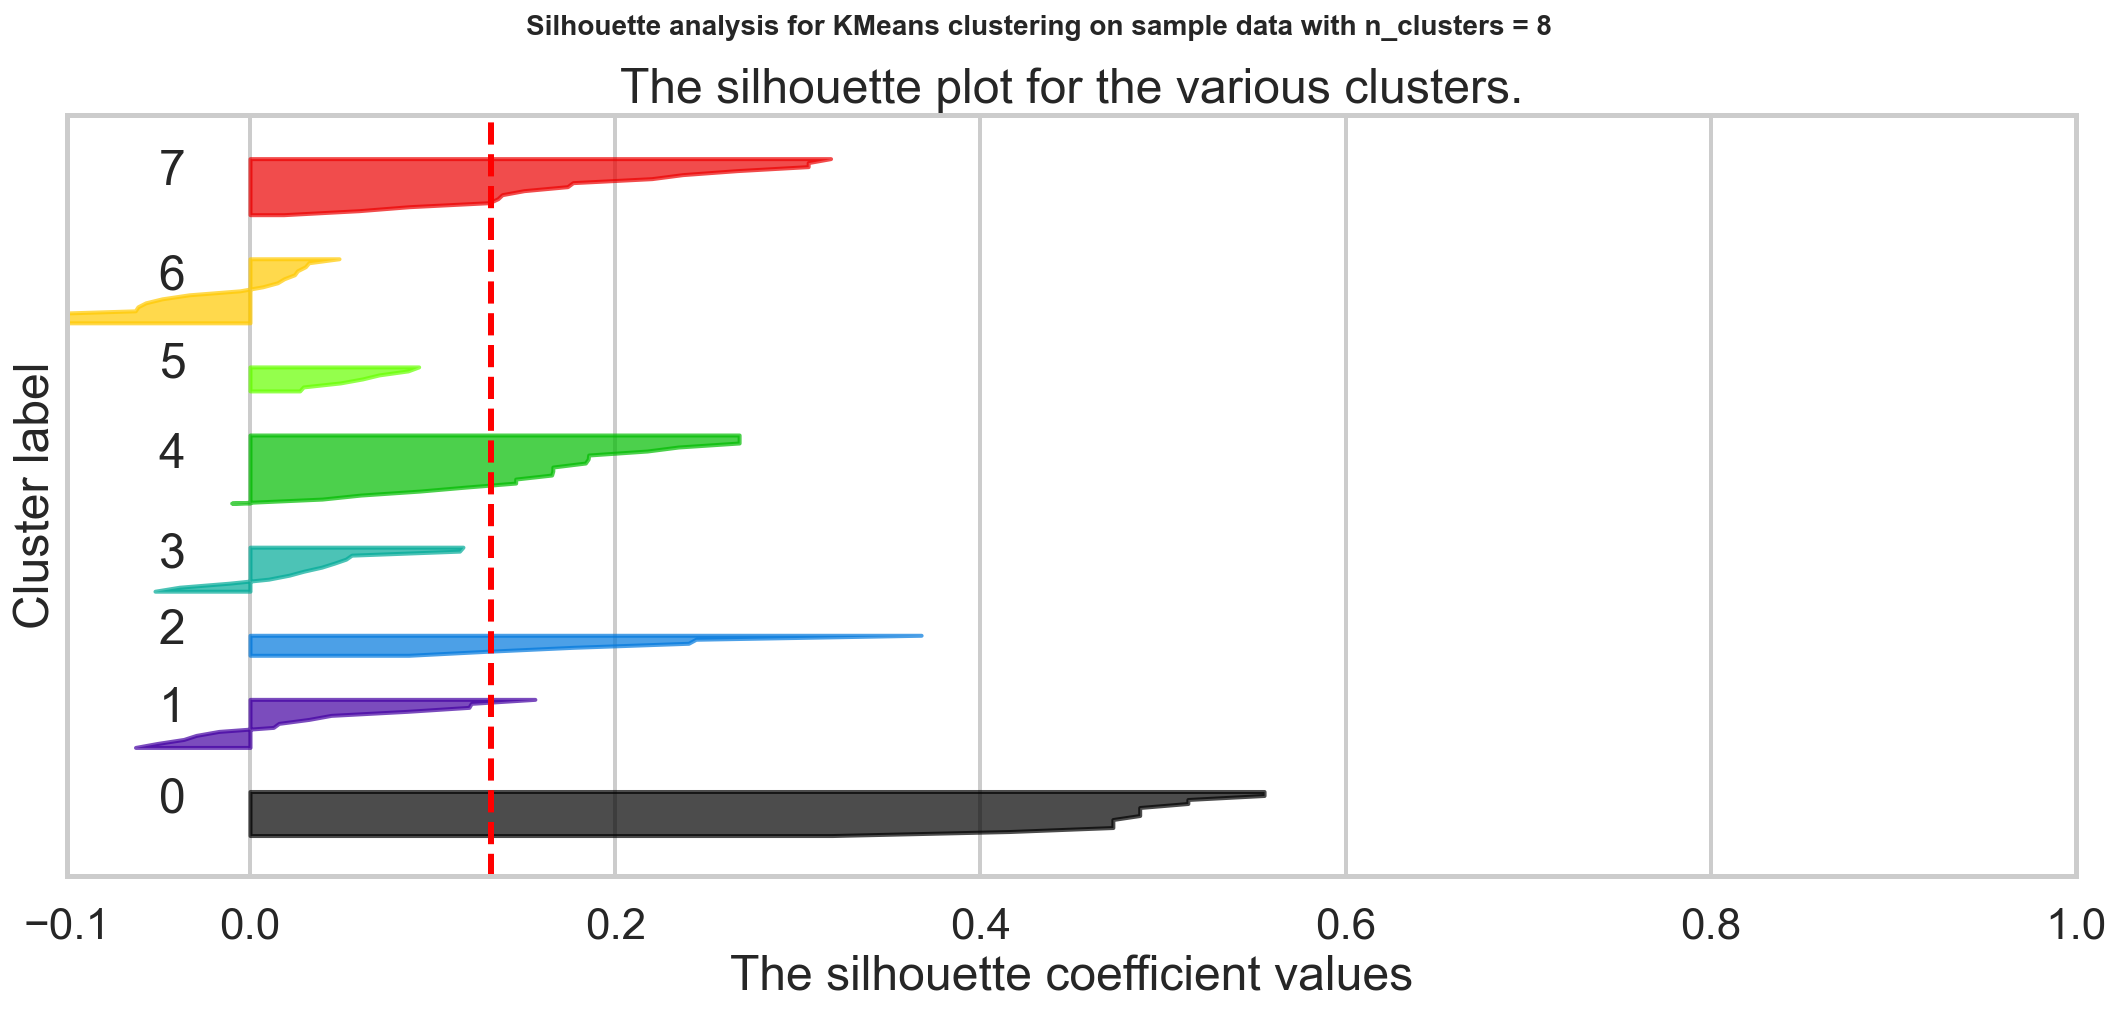

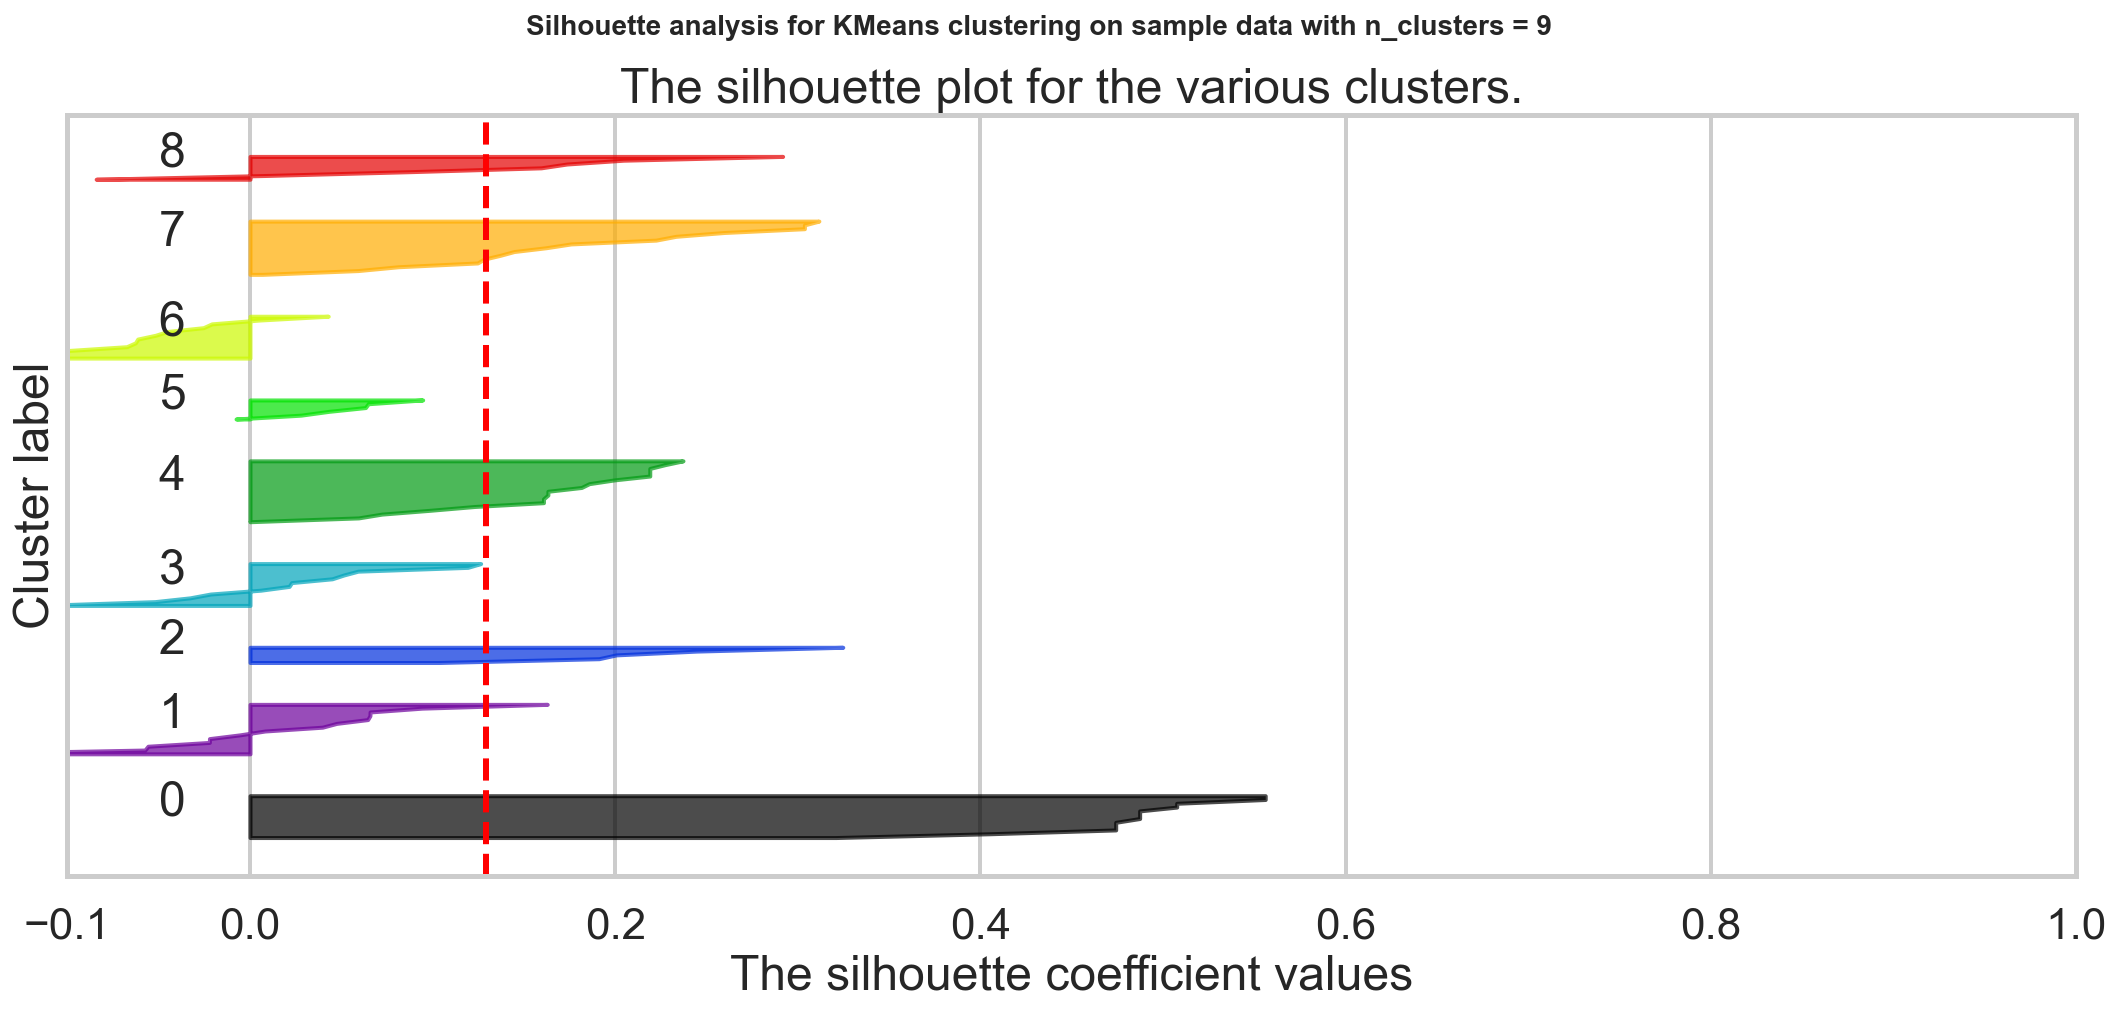

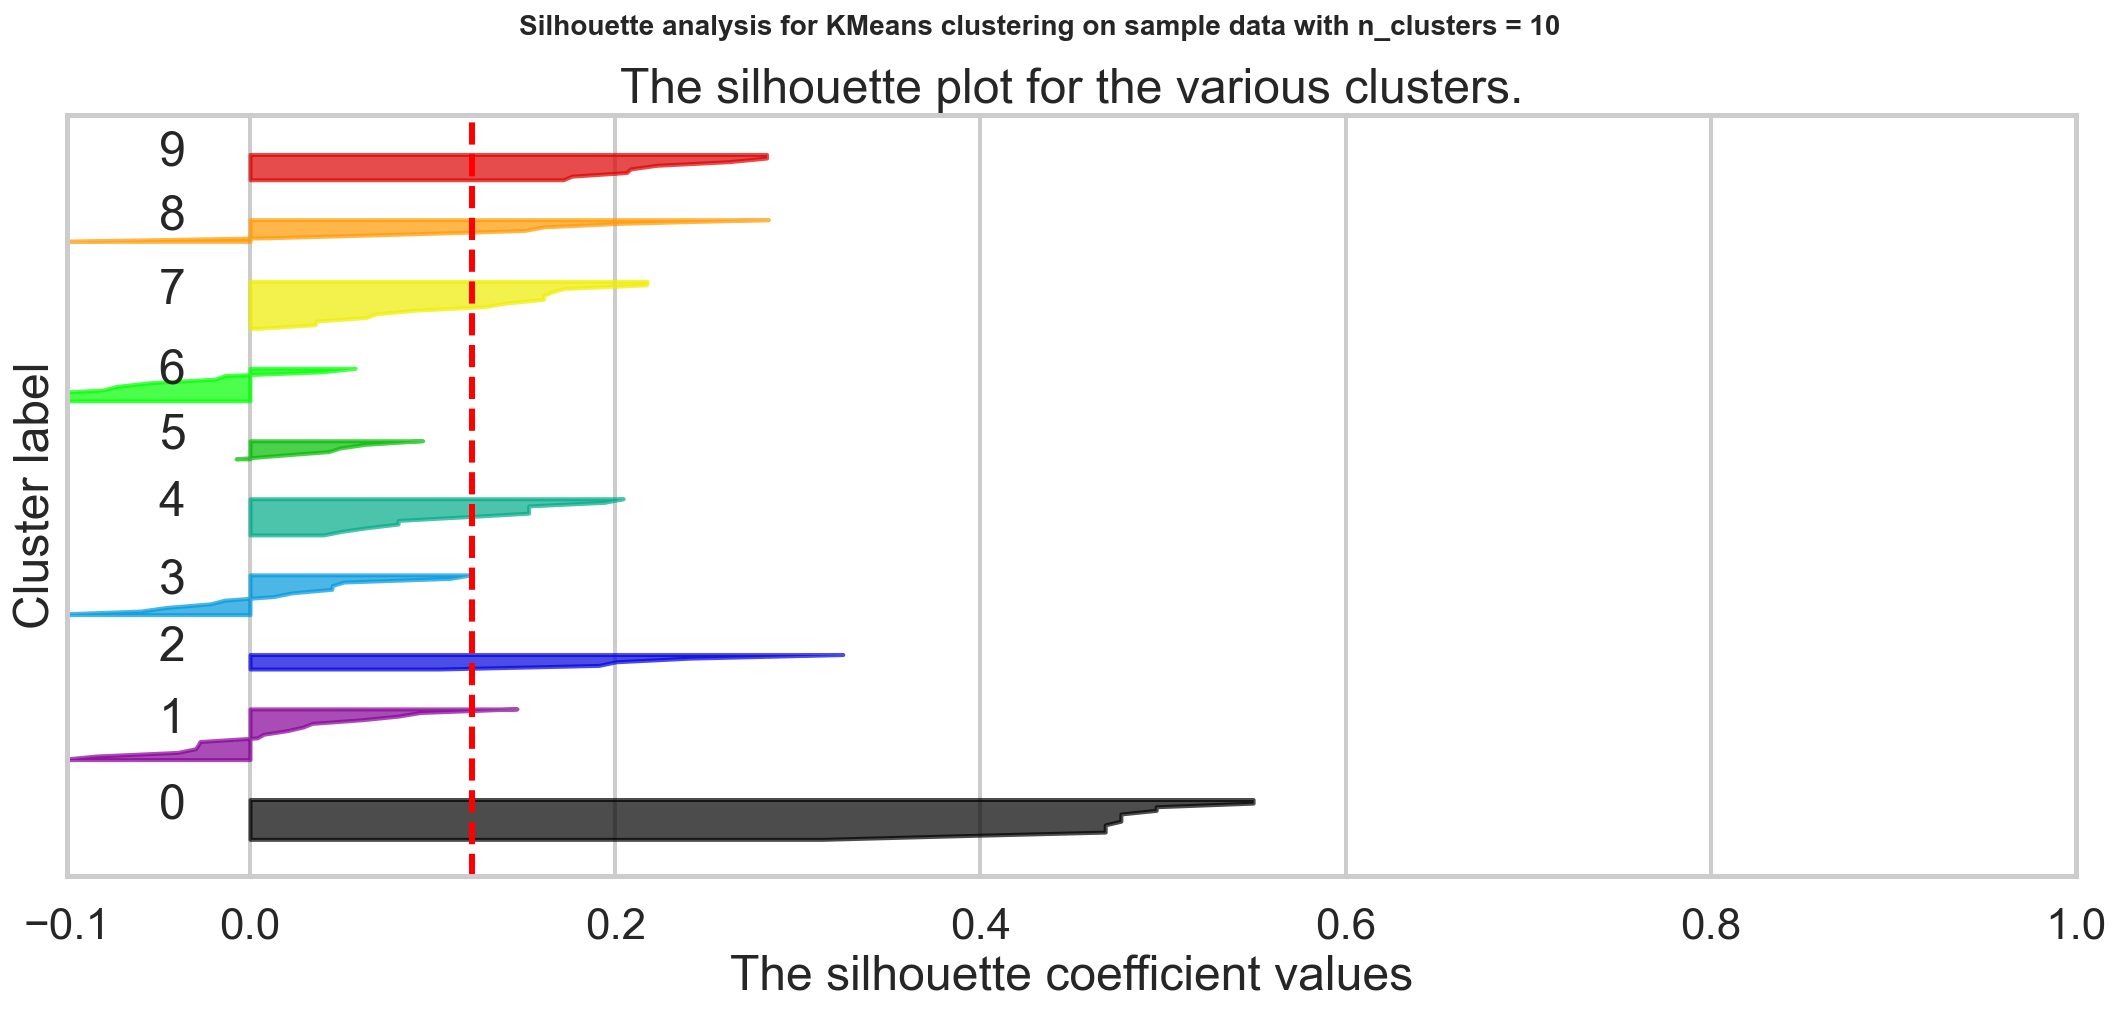

In [11]:
# Your turn. From 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

sil_avg = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sil_avg.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    #colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

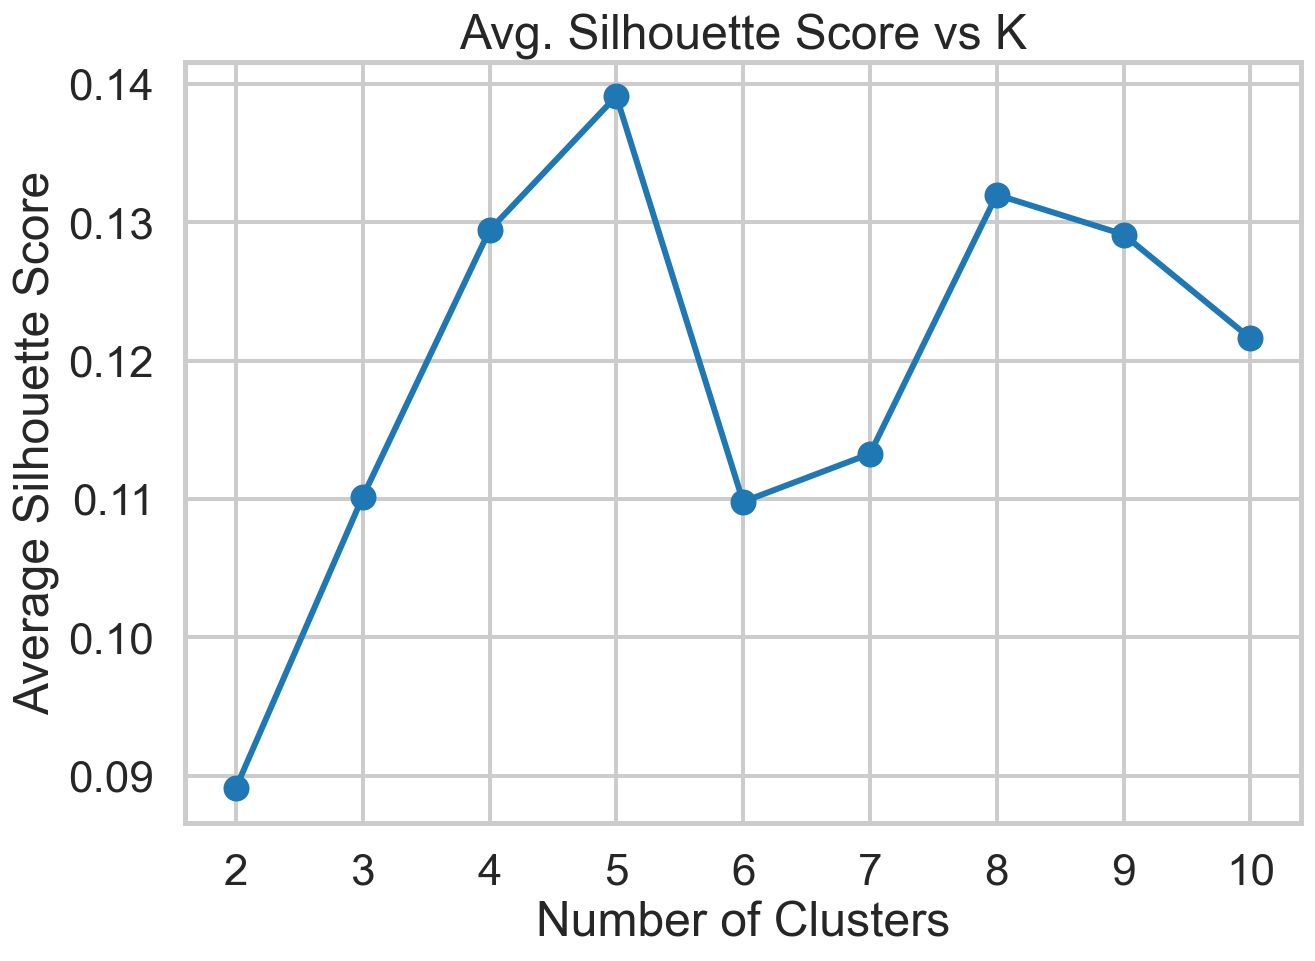

In [12]:
# Plot silhoutte scores
plt.figure(figsize=(10,7))
plt.plot(range_n_clusters,sil_avg,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Avg. Silhouette Score vs K')
plt.xticks(np.arange(2, 11, step=1))
plt.show();

From the silhouette plots above, the highest average score is for 5 clusters. For K=5, we have 2 'distinct' clusters and 3 that are not. This is relative to the average score. 

The second highest is K=8 with 5 'distinct' groups and 3 that are questionable. 

What is best is up to interpretability. Can we distinctly say which customers like what? This will require a more in-depth study.

Based on this, the silhouette method 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [13]:
#your turn
# Create the dataframe containing customer name and cluster association
# Pick K=5

kmeans5 = KMeans(n_clusters=5, random_state=0).fit(x_cols)

In [14]:
# Create DataFrame
df_cluster5 = pd.DataFrame()

# Add customer name
df_cluster5['customer_name'] = df_table.index.values

# Add labels
df_cluster5['cluster'] = kmeans5.labels_
df_cluster5['cluster'] = df_cluster5['cluster'].astype('category')

In [15]:
df_cluster5.head()

customer_name cluster
0         Adams       1
1         Allen       0
2      Anderson       4
3        Bailey       1
4         Baker       2

In [16]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)


fig = px.scatter(components, x=0, y=1, color=df_cluster5['cluster'])

fig.update_layout(
    title={
        'text': "Scatter Plot of PCA=2 for KMeans=5",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [57]:
pca3 = PCA(n_components=3)
components3 = pca3.fit_transform(x_cols)


fig = px.scatter_3d(components3, x=0, y=1,z=2, color=df_cluster5['cluster'])

fig.update_layout(
    title={
        'text': "Scatter Plot of PCA=3 for KMeans=5",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [109]:
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)

kmeans2 = KMeans(n_clusters=2, random_state=0).fit(x_cols)

# Create DataFrame
df_cluster2 = pd.DataFrame()

# Add customer name
df_cluster2['customer_name'] = df_table.index.values

# Add labels
df_cluster2['cluster'] = kmeans2.labels_
df_cluster2['cluster'] = df_cluster2['cluster'].astype('category')


fig = px.scatter(components, x=0, y=1, color=df_cluster2['cluster'])

fig.update_layout(
    title={
        'text': "Scatter Plot of PCA=2 for KMeans=2",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

### Tell a Story from the Data

Adapted from

https://towardsdatascience.com/segmenting-your-customers-on-many-dimensions-or-python-for-wine-lovers-8e7768bf86d6

In [17]:
# Merge the data 
df_cluster5 = df_cluster5.merge(df_table, on = 'customer_name', how = 'right')
df_cluster5.head(10)

customer_name cluster  1  2  3  4  5  6  7  8  ...  23  24  25  26  27  28  \
0         Adams       1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
1         Allen       0  0  0  0  0  0  0  0  0  ...   0   0   0   0   1   0   
2      Anderson       4  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   0   
3        Bailey       1  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   
4         Baker       2  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   
5        Barnes       2  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
6          Bell       4  0  1  0  0  0  0  0  0  ...   0   1   0   1   0   0   
7       Bennett       1  0  0  0  0  0  0  0  1  ...   0   0   0   0   0   0   
8        Brooks       2  0  0  1  0  0  0  0  1  ...   0   0   0   0   0   0   
9         Brown       1  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   

   29  30  31  32  
0   1   1   0   0  
1   0   0   0   0  
2   0   0   0   0  
3   0   1   0   0  
4   0   0   1   0  
5   0   0   1   0  
6   0   0   0   0  
7   1   0   0   0  
8   0   0   0   0  
9   1   1   0   0  

[10 rows x 34 columns]

In [18]:
# Drop the customer names
df_cluster5.drop(['customer_name'],axis=1,inplace=True)

In [19]:
df_cluster5.head(3)

cluster  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  28  29  30  31  \
0       1  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   1   1   0   
1       0  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   0   0   0   0   
2       4  0  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   0   0   0   0   

   32  
0   0  
1   0  
2   0  

[3 rows x 33 columns]

In [20]:
# Group by cluster and sum the number of transactions
df_cluster5_counts = df_cluster5.groupby('cluster').sum()
df_cluster5_counts.head()

1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  27  28  \
cluster                                          ...                           
0         1   1   0   3   2   1   1   0   7   0  ...   1   0   5   2   2   2   
1         0   0   1   0   0   1  14  16   0   2  ...   0   0   0   0   1   1   
2         3   1   5   7   0   7   4   4   0   2  ...   0   0   0   0   5   3   
3         4   1   0   2   2   3   0   0   3   2  ...   3   0   1   2   0   0   
4         2   7   0   0   0   0   0   0   0   1  ...   1  12   0  11   1   0   

         29  30  31  32  
cluster                  
0         1   2   2   2  
1        16  16   0   0  
2         0   3  12   1  
3         0   1   3   1  
4         0   0   0   0  

[5 rows x 32 columns]

In [21]:
# Transpose the cluster counts so we can add the offer details back into the matrix.

df_cluster5_counts_tp = df_cluster5_counts.transpose()
df_cluster5_counts_tp.index.name = "offer_id"
df_cluster5_counts_tp.head()

cluster   0  1  2  3  4
offer_id               
1         1  0  3  4  2
2         1  0  1  1  7
3         0  1  5  0  0
4         3  0  7  2  0
5         2  0  0  2  0

In [22]:
# Now this is super tricky! We have to join the table so that it now has the original features but 
# including the cluster numbers and the number of transactions

df_offer_clusters = df_offers.merge(df_cluster5_counts_tp, on='offer_id', how='right')
#df_offer_clusters = df_offer_clusters[['offer_id'] + [ col for col in df_offer_clusters.columns if col != 'offer_id' ]]


df_offer_clusters.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0        1   January              Malbec       72        56       France   
1        2   January          Pinot Noir       72        17       France   
2        3  February           Espumante      144        32       Oregon   
3        4  February           Champagne       72        48       France   
4        5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  0  1  2  3  4  
0      False  1  0  3  4  2  
1      False  1  0  1  1  7  
2       True  0  1  5  0  0  
3       True  3  0  7  2  0  
4       True  2  0  0  2  0

#### Sort by Cluster

In [27]:
# Sort by Cluster 0

df_offer_cluster0 = df_offer_clusters.sort_values(by=0, ascending=False)
df_offer_cluster0.head(10)

offer_id  campaign            varietal  min_qty  discount       origin  \
10       11       May           Champagne       72        85       France   
8         9     April          Chardonnay      144        57        Chile   
15       16      June              Merlot       72        88   California   
24       25   October  Cabernet Sauvignon       72        59       Oregon   
11       12       May            Prosecco       72        83    Australia   
19       20    August  Cabernet Sauvignon       72        82        Italy   
21       22    August           Champagne       72        63       France   
3         4  February           Champagne       72        48       France   
27       28  November  Cabernet Sauvignon       12        56       France   
26       27   October           Champagne       72        88  New Zealand   

    past_peak  0  1   2  3  4  
10      False  8  0   3  2  0  
8       False  7  0   0  3  0  
15      False  5  0   0  0  0  
24       True  5  0   0  1  0  
11      False  5  0   0  0  0  
19      False  4  0   1  1  0  
21      False  3  0  12  6  0  
3        True  3  0   7  2  0  
27       True  2  1   3  0  0  
26      False  2  1   5  0  1

In [28]:
# Sort by Cluster 1. Customers who prefer a minimum quantity of 6 bottles

df_offer_cluster1 = df_offer_clusters.sort_values(by=1, ascending=False)
df_offer_cluster1.head(10)

offer_id  campaign      varietal  min_qty  discount        origin  \
29       30  December        Malbec        6        54        France   
7         8     March     Espumante        6        45  South Africa   
28       29  November  Pinot Grigio        6        87        France   
6         7     March      Prosecco        6        40     Australia   
17       18      July     Espumante        6        50        Oregon   
12       13       May        Merlot        6        43         Chile   
9        10     April      Prosecco       72        52    California   
2         3  February     Espumante      144        32        Oregon   
5         6     March      Prosecco      144        86         Chile   
20       21    August     Champagne       12        50    California   

    past_peak  0   1  2  3  4  
29      False  2  16  3  1  0  
7       False  0  16  4  0  0  
28      False  1  16  0  0  0  
6        True  1  14  4  0  0  
17      False  0  13  1  0  0  
12      False  0   6  0  0  0  
9       False  0   2  2  2  1  
2        True  0   1  5  0  0  
5       False  1   1  7  3  0  
20      False  0   1  3  0  0

In [29]:
# Sort by Cluster 2. People who seem to like Sparkling beverages

df_offer_cluster2 = df_offer_clusters.sort_values(by=2, ascending=False)
df_offer_cluster2.head(10)

offer_id  campaign            varietal  min_qty  discount        origin  \
30       31  December           Champagne       72        89        France   
21       22    August           Champagne       72        63        France   
3         4  February           Champagne       72        48        France   
5         6     March            Prosecco      144        86         Chile   
18       19      July           Champagne       12        66       Germany   
2         3  February           Espumante      144        32        Oregon   
26       27   October           Champagne       72        88   New Zealand   
6         7     March            Prosecco        6        40     Australia   
7         8     March           Espumante        6        45  South Africa   
27       28  November  Cabernet Sauvignon       12        56        France   

    past_peak  0   1   2  3  4  
30      False  2   0  12  3  0  
21      False  3   0  12  6  0  
3        True  3   0   7  2  0  
5       False  1   1   7  3  0  
18      False  0   0   5  0  0  
2        True  0   1   5  0  0  
26      False  2   1   5  0  1  
6        True  1  14   4  0  0  
7       False  0  16   4  0  0  
27       True  2   1   3  0  0

In [30]:
# Sort by Cluster 3. Perhaps customers who do not prefer wines past their peaks.

df_offer_cluster3 = df_offer_clusters.sort_values(by=3, ascending=False)
df_offer_cluster3.head(10)

offer_id   campaign            varietal  min_qty  discount        origin  \
13       14       June              Merlot       72        64         Chile   
21       22     August           Champagne       72        63        France   
14       15       June  Cabernet Sauvignon      144        19         Italy   
0         1    January              Malbec       72        56        France   
30       31   December           Champagne       72        89        France   
5         6      March            Prosecco      144        86         Chile   
8         9      April          Chardonnay      144        57         Chile   
22       23  September          Chardonnay      144        39  South Africa   
3         4   February           Champagne       72        48        France   
4         5   February  Cabernet Sauvignon      144        44   New Zealand   

    past_peak  0  1   2  3  4  
13      False  0  0   0  9  0  
21      False  3  0  12  6  0  
14      False  1  0   0  5  0  
0       False  1  0   3  4  2  
30      False  2  0  12  3  0  
5       False  1  1   7  3  0  
8       False  7  0   0  3  0  
22      False  1  0   0  3  1  
3        True  3  0   7  2  0  
4        True  2  0   0  2  0

In [31]:
# Sort by Cluster 4. Perhaps customers who prefer Pinot Noir 

df_offer_cluster4 = df_offer_clusters.sort_values(by=4, ascending=False)
df_offer_cluster4.head(10)

offer_id   campaign            varietal  min_qty  discount        origin  \
23       24  September          Pinot Noir        6        34         Italy   
25       26    October          Pinot Noir      144        83     Australia   
16       17       July          Pinot Noir       12        47       Germany   
1         2    January          Pinot Noir       72        17        France   
0         1    January              Malbec       72        56        France   
9        10      April            Prosecco       72        52    California   
26       27    October           Champagne       72        88   New Zealand   
22       23  September          Chardonnay      144        39  South Africa   
5         6      March            Prosecco      144        86         Chile   
19       20     August  Cabernet Sauvignon       72        82         Italy   

    past_peak  0  1  2  3   4  
23      False  0  0  0  0  12  
25      False  2  0  0  2  11  
16      False  0  0  0  0   7  
1       False  1  0  1  1   7  
0       False  1  0  3  4   2  
9       False  0  2  2  2   1  
26      False  2  1  5  0   1  
22      False  1  0  0  3   1  
5       False  1  1  7  3   0  
19      False  4  0  1  1   0

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

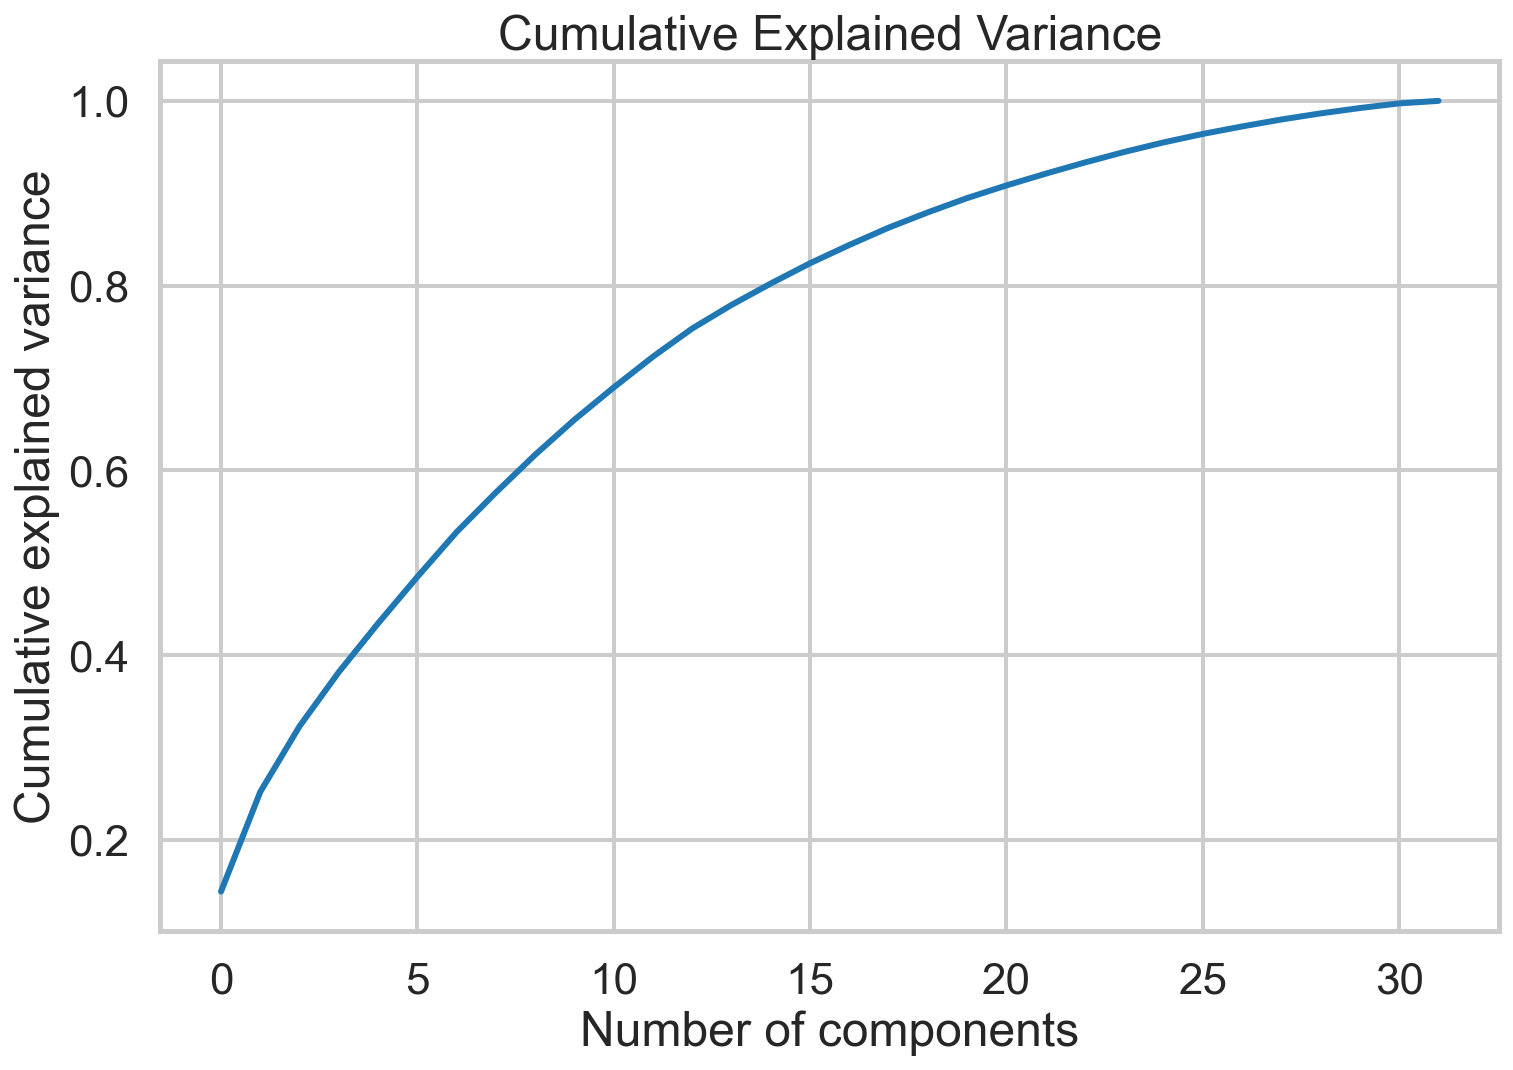

In [23]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition

pcax = sklearn.decomposition.PCA()

pcax.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pcax.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.title('Cumulative Explained Variance');

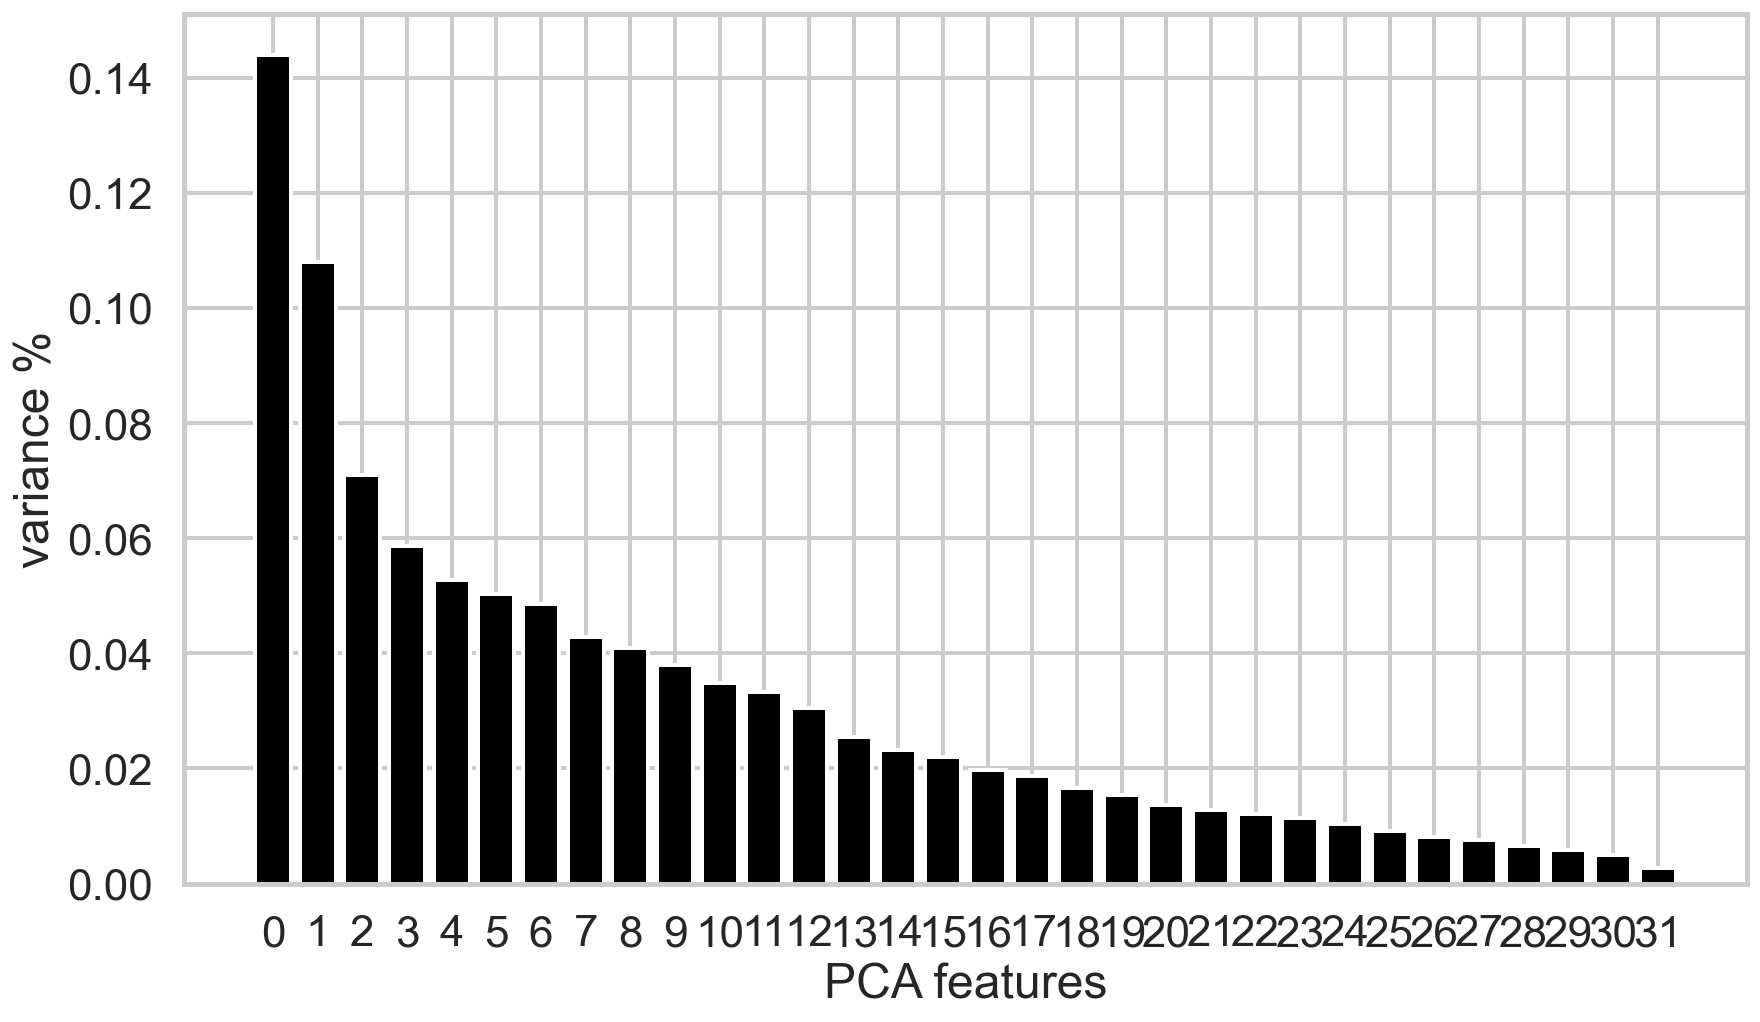

In [24]:
features = range(pcax.n_components_)

plt.figure(figsize=(14,8))
plt.bar(features, pcax.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

The above plot does not appear to show a clear elbow other than components of 2. However, if want to retain 90% variance of the data we will need about 20 components.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [32]:
# Your turn

# Import Libraries
from sklearn.cluster import DBSCAN

In [36]:
x_cols

offer_id       1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  \
customer_name                                          ...                   
Adams           0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Allen           0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   
Anderson        0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   
Bailey          0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   
...            ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
Williams        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Wilson          0   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   
Wood            1   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   
Wright          0   0   0   1   0   1   0   0   0   0  ...   0   0   0   0   
Young           0   0   0   0   0   1   0   0   1   0  ...   0   0   0   0   

offer_id       27  28  29  30  31  32  
customer_name                          
Adams           0   0   1   1   0   0  
Allen           1   0   0   0   0   0  
Anderson        0   0   0   0   0   0  
Bailey          0   0   0   1   0   0  
Baker           0   0   0   0   1   0  
...            ..  ..  ..  ..  ..  ..  
Williams        0   0   0   0   1   0  
Wilson          0   0   0   1   0   0  
Wood            0   0   0   0   1   0  
Wright          1   0   0   0   0   0  
Young           0   0   0   0   1   1  

[100 rows x 32 columns]

In [73]:
# Call DBSCAN
# Density Based Algorithm for Discovering Clusters

dim = len(x_cols.columns) + 2

db = DBSCAN(eps=2, min_samples=dim).fit(x_cols)

df_labels = db.labels_

df_labels


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Strange as all of the labels above are based on noise and do not belong to a group. Perhaps it is best to search for the eps that provides the largest number of sets.

In [110]:
eps = np.linspace(1.5,100,4000)

#print(eps)

num_labels = []
sil_avg_db = []

for i_eps in eps:
    db = DBSCAN(eps=i_eps, min_samples=dim).fit(x_cols)
    labels = db.labels_
        
    num_labels.append(len(set(labels)))


In [111]:
num_labels = np.array(num_labels)

i_eps_max = np.argmax(num_labels)

print(eps[i_eps_max])

1.7463115778944736


In [112]:
db_opt = DBSCAN(eps=eps[i_eps_max], min_samples=dim).fit(x_cols)

labels_opt = db_opt.labels_

print(labels_opt)

[-1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0 -1
  0 -1  0 -1  0  0  0  0  0 -1  0  0 -1 -1 -1 -1  0  0  0  0  0 -1  0  0
 -1 -1 -1 -1  0  0 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0
 -1  0  0  0  0 -1  0  0 -1 -1 -1  0  0  0  0 -1  0  0  0  0  0  0 -1  0
  0  0  0 -1]


In this case, DBSCAN can only ascertain a maximum of two clusters, 1. Noise (-1) and 2. Cluster 0. There has to be more pedagogic way of analyzing this data via DBSCAN.